In [2]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

In [3]:
def mel_spectrogram(audio_file, fs=None, N_fft=1024, H=256, 
                    L=1024, M=80, fmin=20, fmax=8000, eps=1e-10):

    audio, fs = sf.read(audio_file)

    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    window_func = 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(L) / (L - 1))

    stft_matrix = stft(audio, N_fft, H, L, window_func)

    power_spec = np.abs(stft_matrix) ** 2 / N_fft

    mel_filters = create_mel_filterbank(fs, N_fft, M, fmin, fmax)

    mel_spec = np.dot(mel_filters, power_spec)

    log_mel_spec = np.log(mel_spec + eps)
    
    return log_mel_spec, fs

In [8]:
def stft(signal, N_fft, H, L, window_func):
    if L < N_fft:
        pad = N_fft - L
        window_func = np.pad(window_func, (0, pad))

    n_frames = 1 + (len(signal) - L) // H

    stft_matrix = np.zeros((N_fft // 2 + 1, n_frames), dtype=np.complex128)
    
    for i in range(n_frames):
        start = i * H
        end = start + L

        frame = signal[start:end]
        if len(frame) < N_fft:
            frame = np.pad(frame, (0, N_fft - len(frame)))

        windowed_frame = frame * window_func

        fft_result = np.fft.fft(windowed_frame, n=N_fft)
        stft_matrix[:, i] = fft_result[:N_fft // 2 + 1]
    
    return stft_matrix

In [5]:
def create_mel_filterbank(fs, N_fft, M, fmin, fmax):
    def hz_to_mel(freq):
        return 2595 * np.log10(1 + freq / 700)
    
    def mel_to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)
    
    mel_min = hz_to_mel(fmin)
    mel_max = hz_to_mel(fmax)

    mel_points = np.linspace(mel_min, mel_max, M + 2)

    hz_points = mel_to_hz(mel_points)

    bin_points = np.floor((N_fft + 1) * hz_points / fs).astype(int)

    filters = np.zeros((M, N_fft // 2 + 1))

    for i in range(1, M + 1):
        left = bin_points[i - 1]
        center = bin_points[i]
        right = bin_points[i + 1]

        if center > left:
            filters[i - 1, left:center] = np.linspace(0, 1, center - left)

        if right > center:
            filters[i - 1, center:right] = np.linspace(1, 0, right - center)

    return filters

In [6]:
def plot_mel_spectrogram(mel_spec, sr, hop_length):
    plt.figure(figsize=(12, 6))

    db_spec = 20 * mel_spec / np.log(10)

    times = np.arange(mel_spec.shape[1]) * hop_length / sr
    
    plt.imshow(db_spec, aspect='auto', origin='lower', 
                extent=[times[0], times[-1], 0, mel_spec.shape[0]])
    plt.colorbar(label='dB')
    plt.ylabel('Mel-полосы')
    plt.xlabel('Время (с)')
    plt.title('Mel-спектрограмма')
    plt.tight_layout()
    plt.show()


Размерность: (80, 30457)
Частота дискретизации: 44100 Гц
Количество Mel-полос: 80
Количество фреймов: 30457


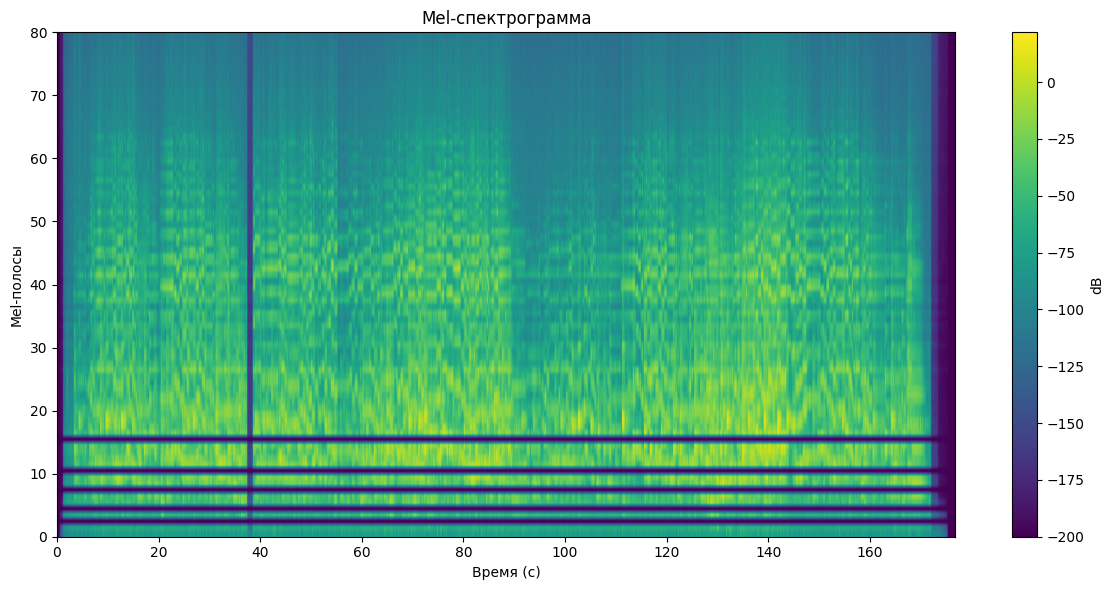

In [9]:
audio_file = "AEG_1934.mp3"

mel_spec, fs = mel_spectrogram(
    audio_file,
    N_fft=1024,
    H=256,
    L=800,
    M=80,
    fmin=20,
    fmax=8000
)

print(f"Размерность: {mel_spec.shape}")
print(f"Частота дискретизации: {fs} Гц")
print(f"Количество Mel-полос: {mel_spec.shape[0]}")
print(f"Количество фреймов: {mel_spec.shape[1]}")

plot_mel_spectrogram(mel_spec, fs, 256)